# HA Chapter 8: Exponential Smoothing

In [1]:
#| echo : false
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# | echo : false
pd.set_option('display.max_columns', 10)
plt.rcParams['figure.figsize'] = (10, 6)

## Exercise 8.1

Consider the the number of pigs slaughtered in Victoria, available in the aus_livestock dataset.


In [3]:
#| echo : false
aus_livestock = pd.read_csv('c:/Users/nickc/DataScience/NickAMC.github.io/DATA_624_S24/rdata/aus_livestock.csv', parse_dates=True, index_col = 'Month')
aus_livestock 

C:\Users\nickc\AppData\Local\Temp\ipykernel_34420\3034126730.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  aus_livestock = pd.read_csv('c:/Users/nickc/DataScience/NickAMC.github.io/DATA_624_S24/rdata/aus_livestock.csv', parse_dates=True, index_col = 'Month')


,Unnamed: 0,Animal,State,Count
Month,,,,
1976-07-01,1,"Bulls, bullocks and steers",Australian Capital Territory,2300.0
1976-08-01,2,"Bulls, bullocks and steers",Australian Capital Territory,2100.0
1976-09-01,3,"Bulls, bullocks and steers",Australian Capital Territory,2100.0
1976-10-01,4,"Bulls, bullocks and steers",Australian Capital Territory,1900.0
1976-11-01,5,"Bulls, bullocks and steers",Australian Capital Territory,2100.0
...,...,...,...,...
2018-08-01,29360,Sheep,Western Australia,160600.0
2018-09-01,29361,Sheep,Western Australia,121900.0
2018-10-01,29362,Sheep,Western Australia,134000.0



### Part A

Use the ETS() function to estimate the equivalent model for simple exponential smoothing. Find the optimal values of α and $ℓ_0$, and generate forecasts for the next four months.



In [4]:
victorian_pigs = aus_livestock.query('Animal == "Pigs" & State == "Victoria"')[['Count']]
victorian_pigs

,Count
Month,
1972-07-01,94200.0
1972-08-01,105700.0
1972-09-01,96500.0
1972-10-01,117100.0
1972-11-01,104600.0
...,...
2018-08-01,102500.0
2018-09-01,82600.0
2018-10-01,100700.0



### Part B

Compute a 95% prediction interval for the first forecast using  $\hat{y}±1.96s$ where $s$ is the standard deviation of the residuals. Compare your interval with the interval produced by R

## Exercise 8.5

Data set `global_economy` contains the annual Exports from many countries. Select one country to analyse.

### Part A 

Plot the Exports series and discuss the main features of the data

In [23]:
global_economy = pd.read_csv("c:/Users/nickc/DataScience/NickAMC.github.io/DATA_624_S24/rdata/global_economy.csv", parse_dates = True)

In [24]:
global_economy = global_economy.set_index('Year')

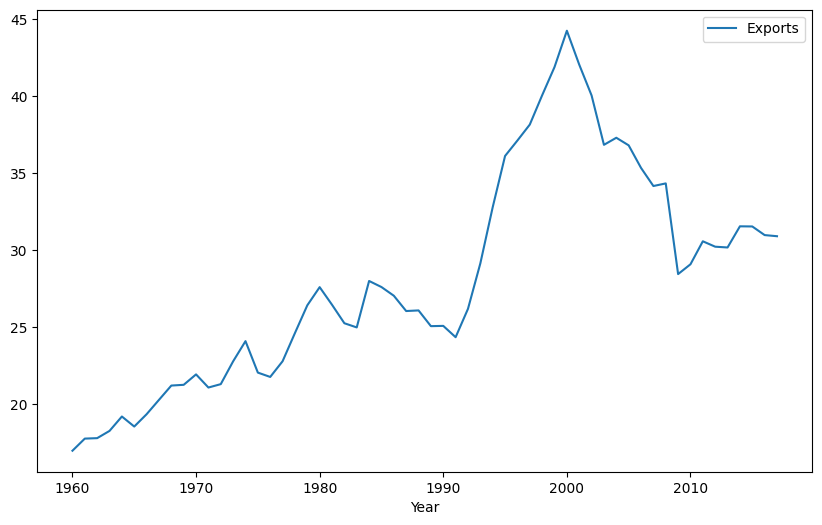

In [25]:
canada_exports = global_economy.query('Country == "Canada"')[['Exports']]

canada_exports.plot()
plt.show()

### Part B

Use an ETS(A,N,N) model to forecast the series, and plot the forecasts

### Part C

Compute the RMSE values for the training data.

### Part D

Compare the results to those from an ETS(A,A,N) model. (Remember that the trended model is using one more parameter than the simpler model.) Discuss the merits of the two forecasting methods for this data set.

### Part E

Compare the forecasts from both methods. Which do you think is best?

### Part F

Calculate a 95% prediction interval for the first forecast for each model, using the RMSE values and assuming normal errors. Compare your intervals with those produced using R.

## Exercise 8.6

Forecast the Chinese GDP from the `global_economy` data set using an ETS model. Experiment with the various options in the ETS() function to see how much the forecasts change with damped trend, or with a Box-Cox transformation. Try to develop an intuition of what each is doing to the forecasts.

[Hint: use a relatively large value of h when forecasting, so you can clearly see the differences between the various options when plotting the forecasts.]

## Exercise 8.7

Find an ETS model for the Gas data from `aus_production` and forecast the next few years. Why is multiplicative seasonality necessary here? Experiment with making the trend damped. Does it improve the forecasts?

## Exercise 8.8

Recall your retail time series data (from Exercise 7 in Section 2.10).

### Part A

Why is multiplicative seasonality necessary for this series?

### Part B

Apply Holt-Winters’ multiplicative method to the data. Experiment with making the trend damped.

### Part C

Compare the RMSE of the one-step forecasts from the two methods. Which do you prefer?

### Part D

Check that the residuals from the best method look like white noise.

### Part E

Now find the test set RMSE, while training the model to the end of 2010. Can you beat the seasonal naïve approach from Exercise 7 in Section 5.11?

## Exercise 8.9

For the same retail data, try an STL decomposition applied to the Box-Cox transformed series, followed by ETS on the seasonally adjusted data. How does that compare with your best previous forecasts on the test set?